In [1]:
import Pkg; 
Pkg.add("BenchmarkTools")
Pkg.add("Plots")
Pkg.add("OrderedCollections")
Pkg.add("Latexify")



    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [2]:
include("./modules.jl")
using LinearAlgebra
using Printf
using Plots
using .MakeGraph
using .BinaryBasisFermions
using .CouplingConstants
using .Operators

anti(A,B)=A*B+B*A
com(A,B)=A*B-B*A

com (generic function with 1 method)

base::Vector{BitVector} - vector of basis states in binary code 

index::Dict{BitVector, Int64} - hash map between the basis states and their indices 

BaseGen(N,cond...) - generates basis of Fock space (Hbert space)with N flavors, cond may restrict the Hilbert spaccce by placing a condition on admissible binvectors, e.g. (occbin,n) selects the states with n particles, (szbin,0) selects the states with Sz=0.

For fermions with spin it is assumed that N is even and the flavors are organized as (...up...|...dn....). This convention encoded in the definition of szbin function.

graph::Vector{Vector{Tuple{Int64, Int64}}} - this is a list of bonds between flavors, Tuple{Int64, Int64}. The graph itself is a Vector of subgraphs Vector{Tuple}. This may appear as an overkill -- it allows to assign each subgraph a different coupling constant.

loopNN(m) - generates a closed loop in nearest-neighbor connections and m sites

Any Hamiltonian with 2-particle interaction has the general form:
$H=\sum_{ij} h^{(1)}_{ij}c_i^\dagger c_j^{\phantom\dagger}+\sum_{ijkl} h^{(2)}_{ijkl}c_i^\dagger c_j^\dagger c_k^{\phantom\dagger}c_l^{\phantom\dagger}$

h1elements::Vector{Tuple{Int64, Int64, Real}}  - list of non-zero elements $(i,j,h^{(1)}_{ij})$

h2elements::Vector{Tuple{Int64, Int64,Int64, Int64, Real}}  - list of non-zero elements $(i,j,k,l,h^{(2)}_{ijkl})$

h1elements and h2elements allow can represent any Hamiltonian of the above type. 

Graph2Hop(graph,norb,t) - generates the h1elements for hoppinng of S=1/2 fermions on graph (the hopping is assumed SU(2) symmetric in spin ='in humnan lagnuage'= hopping upup=dndn of eeaach bond and there is no  updn and dnup hopping. Parameter t is the hopping amplitude.

ChainU(norb,U) - on-site interaction $Un_{i\uparrow}n_{i\downarrow}$ on a chain of 1-orbital atoms (=sites)

H1Gen, H2gen - generate the matrix representation of the operators specified by h1elelements and h2elements in the Hilbert space with basis giiven by base and index.

Ham(u) - generates Hamiltonian with t=1 and variable interaction strength u.

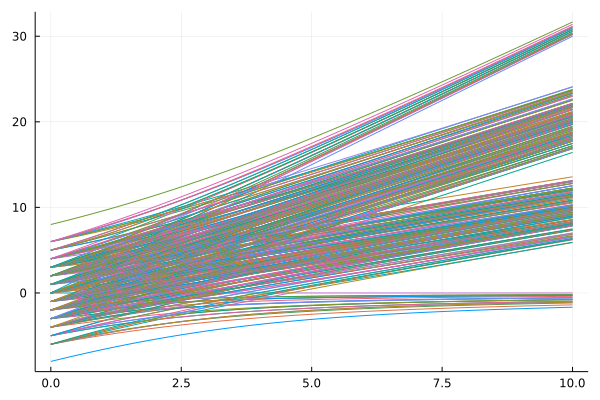

In [61]:
# norb - number of sites/orbitals
# n - number of electrons
norb=6
n=6
base, index = BaseGen(2*norb,(occbin,n),(szbin,0)) 
#base, index = BaseGen(2*norb,(occbin,n))

graph=loopNN(norb)
#pop!.(graph)     #removes the last bonnds, which connects the chain into a loop, i.e. one gets open boundaries

h1elements=Graph2Hop(graph,norb,1.)
h2elements=ChainU(norb,1.)

Ham(u)=H1gen(h1elements,base,index)+u*H2gen(h2elements,base,index)

x=0:0.1:10                 # spectrum as a function of 0<delta<0.1
function spectrum(x::Real)
# y=real.(eigvals(H1gen(h1elements,base,index)+x*H2gen(h2elements,base,index)))
 y=real.(eigvals(Ham(x)))
end
y=reduce(hcat,map(spectrum,x))'
plot(x,y,legend = false)

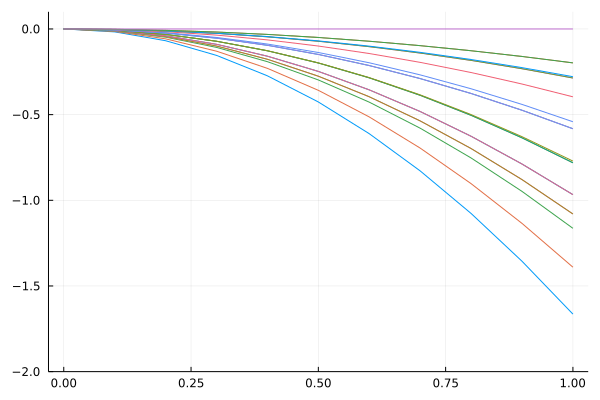

In [5]:
# The same as above with fixed U=10 and variable t
Ham_t(t)=t*H1gen(h1elements,base,index)+10*H2gen(h2elements,base,index)

x=1:-0.1:0                 # spectrum as a function of 0<delta<0.1
function spectrum_t(x::Real)
# y=real.(eigvals(H1gen(h1elements,base,index)+x*H2gen(h2elements,base,index)))
 y=real.(eigvals(Ham_t(x)))
end
y=reduce(hcat,map(spectrum_t,x))'
plot(x,y,legend = false,yrange=(-2,0.1))

gs(H) - eigenstate with the lowest eigenvalue (=ground state), be careful in case the ground state is degenerate (=more given eigenvalue has more than one eigenstate), in this case gs will be just a random vector from the grounnd state subspace

Any 1-particle operator has the general form:
$O=\sum_{ij} o_{ij}c_i^\dagger c_j^{\phantom\dagger}$, and the hooping Hamiltonian is a special example of such a operator.

Sz(norb,i) - generates the list of matrix elements, the same type as h1elements. norb is the number of sites/orbitals, i is the site index.

H1gen - generates the matrix representation of a 1-particle operator

O::Vector{Matrix}=$[S^z_1S^z_2,S^z_2,S^z_3,...]$, each element is a matrix of the size of the selectee Hilbert space.

In [63]:
gs(H)=eigvecs(H)[:,1]
O=[H1gen(Sz(norb,1),base,index)*H1gen(Sz(norb,2),base,index),H1gen(Sz(norb,1),base,index)*H1gen(Sz(norb,3),base,index),H1gen(Sz(norb,1),base,index)*H1gen(Sz(norb,4),base,index)]
    ;

mean(x) - calculates a grounstate expectation values $\langle g(x)|O_a|g(x)\rangle$  of a Hamitonian Ham(x)  for a list of operators and plots them.


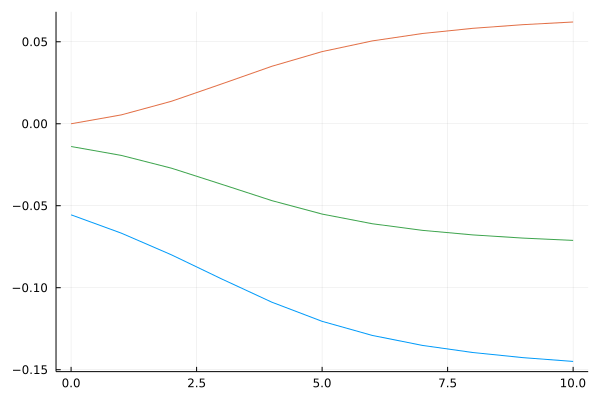

In [64]:
x=0:1:10                 # spectrum as a function of 0<delta<0.1
function mean(x::Real)
      v = gs(Ham(x))
      y = map(A->real.(v'*A*v),O)
end
y=reduce(hcat,map(mean,x))'
plot(x,y,legend = false)

Above: The spin-spin correlation functions on the lattice $\langle S^z_i S^z_j\rangle$. Here this shorthand stands for 
$\langle g(x)|S^z_i S^z_j|g(x)\rangle$. Later we will use it also for thermal averege, i.e. for $\frac{1}{Z}\operatorname{Tr} (e^{-\beta H(x)}S^z_i S^z_j)$. The meaning shall be clear from the context.

kpts - list of k-points for 1D loop os norb site $\frac{2\pi}{norb}*[0,1,...,norb-1]$

Szk(k)::Matrix -- generates a Bloch sum $S^z_k=\sum_{r=1}^{norb} e^{ikr}S^z_r$. Note that $Szk(1)$ corresponds to the $\Gamma$ point, i.e., it is the total $S^z$ (= sum over all sites/atoms).

In [36]:
kpts=[(2*pi/norb)*i for i=0:(norb-1)]

function Szk(k::Int)
    out = zeros(Complex,length(base),length(base))
    for i in 1:norb
        out += H1gen(Sz(norb,i),base,index)*exp(im*kpts[k]*i)
    end
    return out
end

Szk (generic function with 1 method)

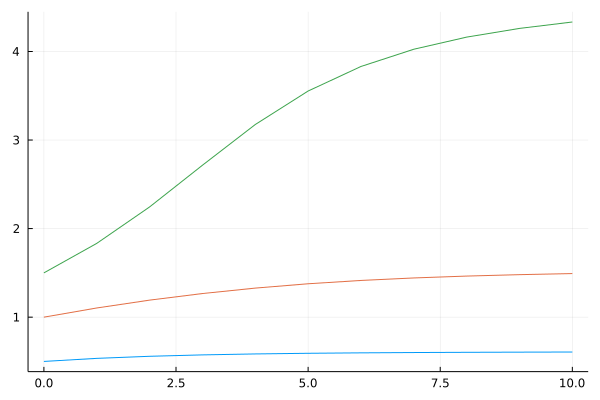

In [66]:
O=[Szk(2)*Szk(6),Szk(3)*Szk(5),Szk(4)*Szk(4)]

x=0:1:10                 # spectrum as a function of 0<delta<0.1
function mean(x::Real)
      v = gs(Ham(x))
      y = map(A->real.(v'*A*v),O)
end
y=reduce(hcat,map(mean,x))'
plot(x,y,legend = false)

Above: The spin-spin correlation functions on the lattice $\langle S^z_k S^z_{k'}\rangle$. Note that if there is a translational symmetry $\langle S^z_k S^z_{k'}\rangle\propto \delta_{k,-k'}$.

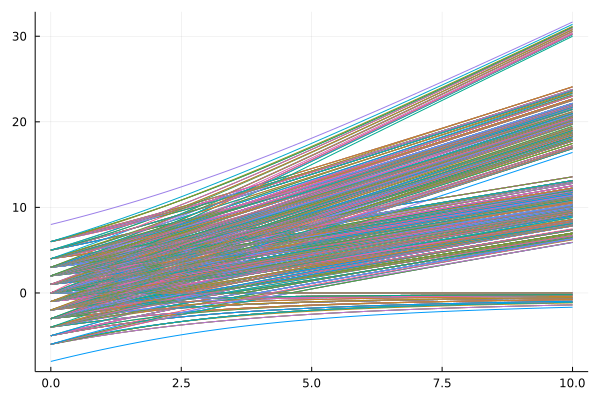

In [67]:
# norb - number of sites/orbitals
# n - number of electrons
norb=6
n=6
base, index = BaseGen(2*norb,(occbin,n)) 
#base, index = BaseGen(2*norb,(occbin,n))

graph=loopNN(norb)
#pop!.(graph)     #removes the last bonnds, which connects the chain into a loop, i.e. one gets open boundaries

h1elements=Graph2Hop(graph,norb,1.)
h2elements=ChainU(norb,1.)

Ham(u)=H1gen(h1elements,base,index)+u*H2gen(h2elements,base,index)

x=0:0.1:10                 # spectrum as a function of 0<delta<0.1
function spectrum(x::Real)
# y=real.(eigvals(H1gen(h1elements,base,index)+x*H2gen(h2elements,base,index)))
 y=real.(eigvals(Ham(x)))
end
y=reduce(hcat,map(spectrum,x))'
plot(x,y,legend = false)

In [50]:
# calculate sum_i,j |x_ij|^2
function magn(x::Matrix)
    tot = 0.
    for y in x
        tot += conj(y)*y
    end
    return tot
end

magn (generic function with 1 method)

$[S^x_1,S^y_1]-iS^z_1=0$

In [53]:
magn(com(H1gen(Sx(6,1),base,index),-im*H1gen(iSy(6,1),base,index))-im*H1gen(Sz(6,1),base,index))

0.0 + 0.0im

In [68]:
O=[H1gen(Sz(norb,1),base,index)*H1gen(Sz(norb,2),base,index),H1gen(Sx(norb,1),base,index)*H1gen(Sx(norb,2),base,index),-H1gen(iSy(norb,1),base,index)*H1gen(iSy(norb,2),base,index)]
    ;

$\langle S^z_1S^z_2\rangle=\langle S^x_1S^x_2\rangle=\langle S^y_1S^y_2\rangle$

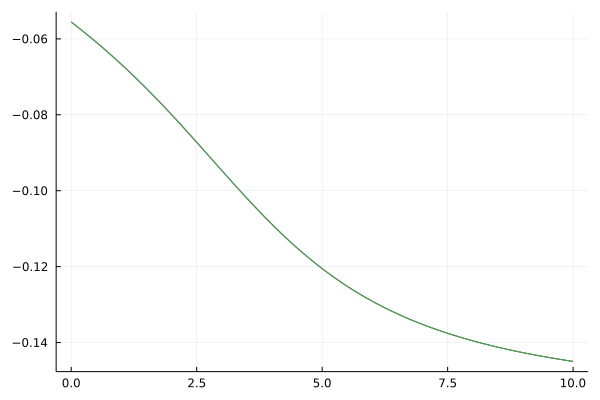

In [70]:
x=0:0.1:10                 
function mean(x::Real)
      v = gs(Ham(x))
      y = map(A->real.(v'*A*v),O)
end
y=reduce(hcat,map(mean,x))'
plot(x,y,legend = false)